### Outlook
* Stochastic Depth 
* Warm up 
* Label Smoothing 
* No Bias Weight Decay 
* Teacher-Student Knowledge Distillation 
* Mixup 
* Group Normalization 
* Weight Standardization 

---

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#### Stochastic Depth

In [65]:
class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """

    def basic_forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out = self.se_module(out) + residual
        out = self.relu(out)
        return out

    def forward(self, x):

        if not self.training:
            out = self.basic_forward(x)
            return out
        else:
            if not self.stochastic_depth:
                out = self.basic_forward(x)
                return out
            else:
                actives = torch.bernoulli(self.probability)
                if actives == 0:
                    print("skip")
                    return x
                else:
                    print("run")
                    out = self.basic_forward(x)
                    return out

class SEModule(nn.Module):
    def __init__(self, channels, reduction):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1, padding=0)


        self.fc2 = nn.Conv2d(
            channels // reduction, channels, kernel_size=1, padding=0
        )

        self.relu = nn.LeakyReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x
    

class SEBottleneck(Bottleneck):

    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        groups,
        reduction,
        stride=1,
        downsample=None,
        stochastic_depth=True,
        probability=torch.tensor(0.8),
    ):
        super().__init__()
        self.stochastic_depth = stochastic_depth
        self.probability = probability
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.conv2 = nn.Conv2d(
            planes * 2,
            planes * 4,
            kernel_size=3,
            stride=stride,
            padding=1,
            groups=groups,
            bias=False,
        )
        self.conv3 = nn.Conv2d(planes * 4, planes, kernel_size=1, bias=False)


        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.bn3 = nn.BatchNorm2d(planes)

        self.relu = nn.LeakyReLU(inplace=True)
        self.se_module = SEModule(
            planes,
            reduction=reduction,)
        self.downsample = downsample
        self.stride = stride


In [66]:
model = SEBottleneck(32, 32, 1, 4).train()

In [67]:
input_features = torch.randn(4, 32, 32, 32)
ouptut = model(input_features)

skip


In [71]:
# bernoulli
value = 0
count = 10000
for _ in range(count):
    value += torch.bernoulli(torch.tensor(0.8))
print((value / count).item())

0.8021000027656555


---

#### Warm up 

In [72]:
import math

from torch.optim import Optimizer

## modify from source : https://github.com/Tony-Y/pytorch_warmup#radam-warmup


class BaseWarmup:
    """Base class for all warmup schedules
    Arguments:
        optimizer (Optimizer): an instance of a subclass of Optimizer
        warmup_params (list): warmup paramters
        last_step (int): The index of last step. (Default: -1)
    """

    def __init__(self, optimizer: Optimizer, warmup_params, last_step=-1):
        self.optimizer = optimizer
        self.warmup_params = warmup_params
        self.last_step = last_step
        self.step()

    def state_dict(self):
        """Returns the state of the warmup scheduler as a :class:`dict`.
        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        """
        return {
            key: value for key, value in self.__dict__.items() if key != "optimizer"
        }

    def load_state_dict(self, state_dict):
        """Loads the warmup scheduler's state.
        Arguments:
            state_dict (dict): warmup scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        self.__dict__.update(state_dict)

    def step(self, step=None):
        """Dampen the learning rates.
        Arguments:
            step (int): The index of current step. (Default: None)
        """
        if step is None:
            step = self.last_step + 1
        self.last_step = step

        for group, params in zip(self.optimizer.param_groups, self.warmup_params):
            omega = self.warmup_factor(step, **params)
            group["lr"] *= omega

    def warmup_factor(self, step, **params):
        raise NotImplementedError


class ExponentialWarmup(BaseWarmup):
    """Exponential warmup schedule.
    Arguments:
        optimizer (Optimizer): an instance of a subclass of Optimizer
        warmup_period (int or list): Effective warmup period
        last_step (int): The index of last step. (Default: -1)
    """

    def __init__(self, optimizer, warmup_period, last_step=-1):
        group_count = len(optimizer.param_groups)
        warmup_params = [dict(warmup_period=warmup_period) for _ in range(group_count)]
        super().__init__(optimizer, warmup_params, last_step)

    def warmup_factor(self, step, warmup_period):
        return 1.0 - math.exp(-(step + 1) / warmup_period)

In [76]:
from torchvision import models
from torch import optim
model = models.resnet18()

In [81]:
num_steps = 1000
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
warmup_scheduler = ExponentialWarmup(optimizer, warmup_period=num_steps // 10)

In [84]:
lr_ = []
for _ in range(num_steps):
    lr_scheduler.step(lr_scheduler.last_epoch + 1)
    warmup_scheduler.step()
    lr_.append(optimizer.param_groups[0]["lr"])

/Users/jeff.yang/opt/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/Users/jeff.yang/opt/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

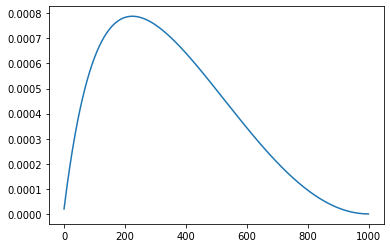

In [89]:
plt.plot(lr_)
plt.show()

---

#### Label smoothing

In [107]:
from typing import Union
import numpy as np

class LabelSmoothing(nn.Module):
    def __init__(self, classes: int, smoothing: float = 0.1):
        super().__init__()
        assert 0 <= smoothing < 1
        if not smoothing:
            self.criterion_entropy = nn.CrossEntropyLoss()
            print("Deactivated smoothing, apply CrossEntropyLoss.")
        else:
            self.criterion = nn.KLDivLoss(reduction="batchmean")
            print("Activated smoothing, apply KLDivLoss.")

        self.classes = classes
        self.smoothing = smoothing
        self.confidence = 1 - smoothing

    @torch.no_grad()
    def convert_label_to_smooth(self, true_labels: torch.Tensor):
        label_shape = torch.Size((true_labels.size(0), self.classes))
        true_dist = torch.empty(size=label_shape, device=true_labels.device)
        true_dist.fill_(self.smoothing / (self.classes - 1))
        true_dist = true_dist.scatter_(1, true_labels.data, self.confidence)
        return true_dist

    def forward(
        self, prediction: torch.Tensor, true_labels: Union[np.ndarray, torch.Tensor]
    ):
        """
        prediction  -> shape == [batch, self.classes]
        true_labels -> shape == [batch, 1]
        """
        if prediction.shape[1] != self.classes:
            raise ValueError(
                f"Mismatch between prediction and specified class number, have pre-specified classes equal to {self.classes} while {prediction.shape[1]} in prediction"
            )
        if not isinstance(true_labels, torch.Tensor):
            true_labels = torch.tensor(true_labels, dtype=torch.long)
        else:
            true_labels = true_labels.type(torch.long)
        if self.smoothing:
            print(true_labels)
            print("----------")
            true_labels = self.convert_label_to_smooth(true_labels.reshape(-1, 1))
            print("convert to smooth")
            print("----------")
            print(true_labels)
            prediction = prediction.log_softmax(-1)
            loss = self.criterion(prediction, true_labels)
        else:
            loss = self.criterion_entropy(prediction, true_labels.reshape(-1))
        return loss

In [108]:
model = LabelSmoothing(5)

Activated smoothing, apply KLDivLoss.


In [109]:
prediction = torch.randn(4, 5)
label = torch.tensor([0, 4, 3, 1]).reshape(4, 1)

In [110]:
loss = model(prediction, label)

tensor([[0],
        [4],
        [3],
        [1]])
----------
convert to smooth
----------
tensor([[0.9000, 0.0250, 0.0250, 0.0250, 0.0250],
        [0.0250, 0.0250, 0.0250, 0.0250, 0.9000],
        [0.0250, 0.0250, 0.0250, 0.9000, 0.0250],
        [0.0250, 0.9000, 0.0250, 0.0250, 0.0250]])


---

#### No Bias Weight Decay

In [111]:
def add_weight_decay(net, l2_value, skip_list=[]):
    decay, no_decay = [], []
    for name, param in net.named_parameters():
        if not param.requires_grad:
            continue  # skip frozen weights
        # skip bias and bn layer
        if name.endswith(".bias") or ("_bn" in name) or (name in skip_list):
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {"params": no_decay, "weight_decay": 0.0},
        {"params": decay, "weight_decay": l2_value},
    ]

In [112]:
model = models.resnet18()
parameters = add_weight_decay(model, 0.00001)

In [115]:
parameters[0]["weight_decay"]

0.0

In [116]:
parameters[1]["weight_decay"]

1e-05

---

#### Mixup

In [203]:
from torch.distributions.beta import Beta


class Mixup(nn.Module):
    def __init__(self, alpha: float = 0.2):
        super().__init__()
        self.alpha = alpha
        self.criterion = nn.CrossEntropyLoss()
        self.beta = Beta(alpha, alpha)

    def __get_mixup_batch(
        self, mini_batch_image: torch.Tensor, mini_batch_label: torch.Tensor
    ):
        lambda_ = self.beta.sample()
        batch_size = mini_batch_image.shape[0]
        shuffle = torch.randperm(batch_size)
        shuffle_mini_batch_x = mini_batch_image[shuffle]
        shuffle_mini_batch_y = mini_batch_label[shuffle]
        mixup_x = mini_batch_image * lambda_ + (1 - lambda_) * shuffle_mini_batch_x
        return (
            mixup_x,
            mini_batch_label.reshape(-1),
            shuffle_mini_batch_y.reshape(-1),
            lambda_,
        )

    def forward(
        self,
        model: nn.Module,
        mini_batch_image: torch.Tensor,
        mini_batch_label: torch.Tensor,
    ):
        """
        mini_batch_image -> shape == [batch, channel, height, width]
        mini_batch_label -> shape == [batch, 1] or [batch]
        """
        (
            mixup_x,
            mini_batch_label,
            shuffle_mini_batch_y,
            lambda_,
        ) = self.__get_mixup_batch(mini_batch_image, mini_batch_label)
        output = model(mixup_x)
        loss = self.criterion(output, mini_batch_label) * lambda_ + (
            1 - lambda_
        ) * self.criterion(output, shuffle_mini_batch_y)
        return mixup_x, loss

In [204]:
trainer = Mixup()
model = models.resnet18()

In [205]:
mini_batch_image = torch.cat((torch.ones(3, 3, 64, 64) , torch.zeros(3, 3, 64, 64)), 0)
mini_batch_label = torch.tensor([1, 1, 1, 0, 0, 0])

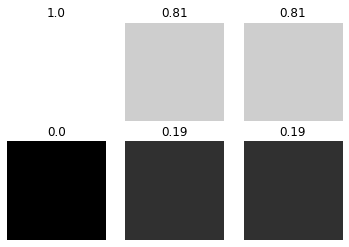

In [212]:
image_, loss = trainer(model, mini_batch_image, mini_batch_label)
for _ in range(6):
    plt.subplot(231+_)
    plt.title(round((image_[_].mean()).item(), 2))
    plt.axis('off')
    plt.imshow(image_[_].permute(1, 2, 0))
plt.show()

---

#### Teacher-Student Knowledge Distillation

In [213]:
from typing import Union

import torch
import torch.nn as nn


class DistillationLoss(nn.Module):
    def __init__(self, temperature: Union[int, float] = 2):
        super().__init__()
        self.criterion = nn.KLDivLoss(reduction="batchmean")
        self.temperature = temperature
        self.softmax = nn.Softmax(1)
        self.logsoftmax = nn.LogSoftmax(1)

    def forward(self, student_output: torch.Tensor, teacher_output: torch.Tensor):
        """
        student_output -> shape == [batch, class_number]
        teacher_output -> shape == [batch, class_number]
        """

        if student_output.shape != teacher_output.shape:
            raise ValueError(
                f"Mismatch between student_output and teacher_output, got student_output : {student_output.shape} & teacher_output : {teacher_output.shape} respectively"
            )
        student_output = self.logsoftmax(student_output / self.temperature)
        teacher_output = self.softmax(teacher_output / self.temperature)

        loss = (
            self.criterion(student_output, teacher_output)
            * self.temperature
            * self.temperature
        )
        return loss

In [214]:
distill = DistillationLoss()

In [215]:
student_output = torch.randn(32, 4)
teacher_output = torch.randn(32, 4)
loss = distill(student_output, teacher_output)

---

#### Weight Standardization 

In [218]:
class Conv2d(nn.Conv2d):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(Conv2d, self).__init__(in_channels, out_channels, kernel_size, stride,
                 padding, dilation, groups, bias)

    def forward(self, x):
        weight = self.weight
        weight_mean = weight.mean(dim=1, keepdim=True).mean(dim=2,
                                  keepdim=True).mean(dim=3, keepdim=True)
        weight = weight - weight_mean
        std = weight.view(weight.size(0), -1).std(dim=1).view(-1, 1, 1, 1) + 1e-5
        weight = weight / std.expand_as(weight)
        return F.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

In [220]:
model = Conv2d(12, 12, 3)
output = model(torch.randn(1, 12 ,32, 32))

---

![](assets/GN.png)

#### Group Normalization

In [221]:
dummy_input = torch.randn(16, 10, 32, 32)

#### BN

In [222]:
average_ = dummy_input.mean([0, 2, 3], keepdim=True)
std_ = dummy_input.std([0, 2, 3], keepdim=True)
normalization = (dummy_input - average_) / std_

#### GN

In [224]:
## 當N group == 1 時, GN == LN, 當 group == C 時, GN == IN
n_group = 5
dummy_input_copy = dummy_input.clone()
b, c, h, w = dummy_input_copy.size()
dummy_input_copy = dummy_input_copy.reshape(b, n_group, int(c / n_group), h, w)
average_ = dummy_input_copy.mean([2, 3, 4], keepdim=True)
std_ = dummy_input_copy.std([2, 3, 4], keepdim=True)
normalization = (dummy_input_copy - average_) / std_
normalization = normalization.reshape(b, c, h, w)